# Incubator State Estimation with a Particle Filter

This uses `pypfilt` to implement the filtering on the incubator example.

In [1]:
%%writefile incubator_model.py

# If you change this file, you should restart the kernel, otherwise the changes will not be reflected in the simulation

from pypfilt import OdeModel
import sympy as sp
import numpy as np

# Parameters
C_air = sp.Symbol("C_air", real=True)  # Specific heat capacity
G_box = sp.Symbol("G_box", real=True)  # Specific heat capacity
C_heater = sp.Symbol("C_heater", real=True)  # Specific heat capacity
G_heater = sp.Symbol("G_heater", real=True)  # Specific heat capacity

# Constants
V_heater = sp.Symbol("V_heater", real=True)
i_heater = sp.Symbol("i_heater", real=True)

# Inputs
in_room_temperature = sp.Symbol("T_room", real=True)
on_heater = sp.Symbol("on_heater", real=True)

# States
T = sp.Symbol("T", real=True)
T_heater = sp.Symbol("T_heater", real=True)

power_in = on_heater * V_heater * i_heater

power_transfer_heat = G_heater * (T_heater - T)

total_power_heater = power_in - power_transfer_heat

power_out_box = G_box * (T - in_room_temperature)

total_power_box = power_transfer_heat - power_out_box

der_T_heater = (1.0 / C_heater) * (total_power_heater)
der_T = (1.0 / C_air) * (total_power_box)

# Vectorize der_T and der_T_heater so they can be applied to the particles
der_T_heater_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T_heater)
der_T_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T)



class IncubatorModel(OdeModel):

    def field_types(self, ctx):
        r"""
        Define the state vector :math:`[\sigma, \rho, \beta, x, y, z]^T`.
        """
        return [
            ('T_heater', float),
            ('T', float),
            ('C_air', float),
            ('G_box', float),
            ('C_heater', float),
            ('G_heater', float),
            ('V_heater', float),
            ('i_heater', float)
        ]

    def d_dt(self, time, xt, ctx, is_forecast):
        """
        The right-hand side of the ODE system.

        :param time: The current time.
        :param xt: The particle state vectors.
        :param ctx: The simulation context.
        :param is_forecast: True if this is a forecasting simulation.
        """

        # TODO: Lookup inputs
        T_room = 20.0
        on_heater = 0.0

        rates = np.zeros(xt.shape, xt.dtype)

        rates['T_heater'] = der_T_heater_function(xt['T_heater'], xt['T'], xt['C_air'], xt['G_box'], xt['C_heater'], xt['G_heater'], xt['V_heater'], xt['i_heater'], T_room, on_heater)
        rates['T'] = der_T_function(xt['T_heater'], xt['T'], xt['C_air'], xt['G_box'], xt['C_heater'], xt['G_heater'], xt['V_heater'], xt['i_heater'], T_room, on_heater)

        return rates

Overwriting incubator_model.py


In [2]:
%%writefile incubator_obs.py

from pypfilt.obs import Univariate
import scipy.stats

class ObsIncubator(Univariate):

    def distribution(self, ctx, snapshot):
        expect = snapshot.state_vec['T']
        return scipy.stats.norm(loc=expect, scale=0.1)


Overwriting incubator_obs.py


In [3]:
%%writefile incubator_simulate.toml

[components]
model = "incubator_model.IncubatorModel"
time = "pypfilt.Scalar"
sampler = "pypfilt.sampler.LatinHypercube"
summary = "pypfilt.summary.HDF5"

[time]
start = 0.0
until = 300.0
steps_per_unit = 10
summaries_per_unit = 1

[prior]
T_heater = { name = "constant", args.value = 100.0 }
T = { name = "constant", args.value = 100.0 }
C_air = { name = "constant", args.value = 68.0 }
G_box = { name = "constant", args.value = 0.74 }
C_heater = { name = "constant", args.value = 243.0 }
G_heater = { name = "constant", args.value = 0.87 }
V_heater = { name = "constant", args.value = 12.0 }
i_heater = { name = "constant", args.value = 10.45 }

[observations.T]
model = "incubator_obs.ObsIncubator"

[filter]
particles = 500
prng_seed = 2001
history_window = -1
resample.threshold = 0.25

[scenario.simulate]

Overwriting incubator_simulate.toml


In [4]:
import pypfilt

scenario_file = 'incubator_simulate.toml'
instances = list(pypfilt.load_instances(scenario_file))
assert len(instances) == 1
instance = instances[0]
instance

Instance(scenario_id="simulate", descriptor="")

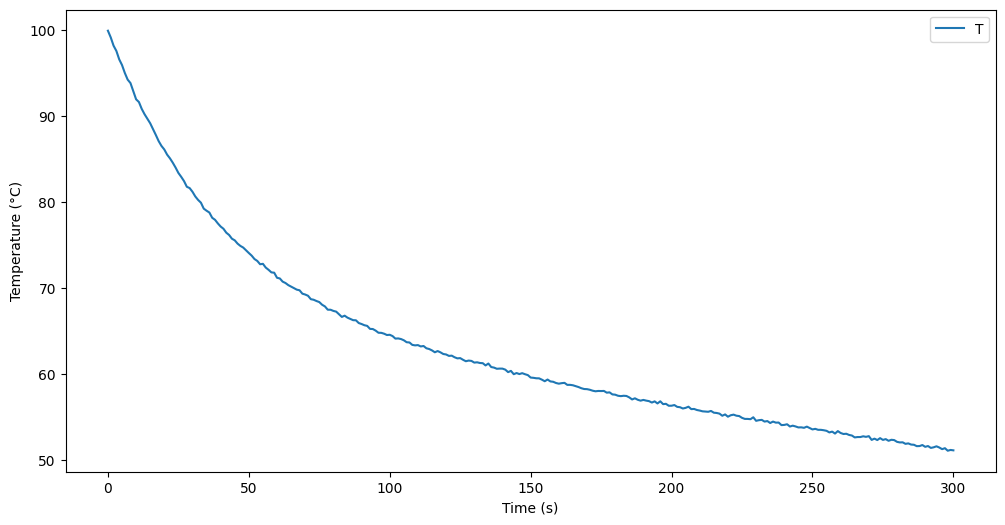

In [5]:
import matplotlib.pyplot as plt

# Simulate observations for T and T_heater.
obs_tables = pypfilt.simulate_from_model(list(pypfilt.load_instances(scenario_file))[0])

# Plot the backcast and forecast against the simulated observations.
plt.figure(figsize=(12, 6))
plt.plot(obs_tables['T']['time'], obs_tables['T']['value'], label='T')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [6]:
# Store the observations in a SSV file
pypfilt.io.write_table('incubator_sim_observations.ssv',obs_tables['T'])

In [7]:
from data_handling import *

# Known heater voltage and current
V_heater = 12.0 
i_heater = 10.45 

# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    V_heater, i_heater,
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=True,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,timestamp_ns,power_in,avg_temp_kelvin,potential_energy,lid_open
0,0.00000,21.312,1611326936960770000,25.000,1611326937840280000,24.812,1611326938720290000,24.9060,False,False,3,2.617681,2021-01-22 14:48:58.720290,0.0,298.0560,0.000,0.0
1,3.04000,21.312,1611326940000310000,25.000,1611326940880730000,24.875,1611326941760290000,24.9375,False,False,3,2.657222,2021-01-22 14:49:01.760290,0.0,298.0875,0.882,0.0
2,5.99999,21.312,1611326942960290000,25.000,1611326943840300000,24.812,1611326944720280000,24.9060,False,False,3,2.616798,2021-01-22 14:49:04.720280,0.0,298.0560,0.000,0.0
3,9.03997,21.312,1611326946000330000,25.000,1611326946880260000,24.812,1611326947760260000,24.9060,False,False,3,2.656322,2021-01-22 14:49:07.760260,0.0,298.0560,0.000,0.0
4,11.99999,21.312,1611326948960360000,25.000,1611326949840270000,24.812,1611326950720280000,24.9060,True,True,3,2.615920,2021-01-22 14:49:10.720280,125.4,298.0560,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1386.23996,21.375,1611328323200280000,34.375,1611328324090060000,30.750,1611328324960250000,32.5625,False,True,3,2.661163,2021-01-22 15:12:04.960250,0.0,305.7125,214.382,0.0
463,1389.19996,21.437,1611328326160300000,34.750,1611328327039630000,31.000,1611328327920250000,32.8750,False,True,3,2.620764,2021-01-22 15:12:07.920250,0.0,306.0250,223.132,0.0
464,1392.23999,21.437,1611328329200330000,35.062,1611328330080280000,31.250,1611328330960280000,33.1560,False,True,3,2.660336,2021-01-22 15:12:10.960280,0.0,306.3060,231.000,0.0
465,1395.19997,21.437,1611328332160320000,35.375,1611328333040270000,31.562,1611328333920260000,33.4685,False,True,3,2.619904,2021-01-22 15:12:13.920260,0.0,306.6185,239.750,0.0


In [8]:
events

,time,event,timestamp_ns
0,1611327598000000000,Lid Opened,2021-01-22 14:59:58
1,1611327658000000000,Lid Closed,2021-01-22 15:00:58
2,1611328159000000000,Lid Opened,2021-01-22 15:09:19
3,1611328225000000000,Lid Closed,2021-01-22 15:10:25


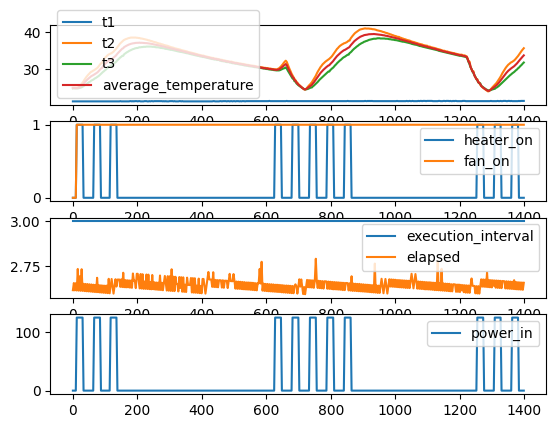

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(data["time"], data["t1"], label="t1")
ax1.plot(data["time"], data["t2"], label="t2")
ax1.plot(data["time"], data["t3"], label="t3")
ax1.plot(data["time"], data["average_temperature"], label="average_temperature")
ax1.legend()

ax2.plot(data["time"], data["heater_on"], label="heater_on")
ax2.plot(data["time"], data["fan_on"], label="fan_on")
ax2.legend()

ax3.plot(data["time"], data["execution_interval"], label="execution_interval")
ax3.plot(data["time"], data["elapsed"], label="elapsed")
ax3.legend()

ax4.plot(data["time"], data["power_in"], label="power_in")
ax4.legend()

plt.show()

In [10]:
# Output observations data to a file that can be read by the filter
incubator_observations = data[["time", "average_temperature"]].copy()
incubator_observations.columns = ["time", "value"]
incubator_observations.to_csv("incubator_observations.ssv", index=False, sep=" ")

In [11]:
%%writefile incubator_forecast.toml
[components]
model = "incubator_model.IncubatorModel"
time = "pypfilt.Scalar"
sampler = "pypfilt.sampler.LatinHypercube"
summary = "pypfilt.summary.HDF5"

[time]
start = 0.0
until = 220.0
steps_per_unit = 10
summaries_per_unit = 10

[prior]
T_heater = { name = "constant", args.value = 24.906 }
T = { name = "constant", args.value = 24.906 }
C_air = { name = "constant", args.value = 68.0 }
G_box = { name = "constant", args.value = 0.74 }
C_heater = { name = "constant", args.value = 243.0 }
G_heater = { name = "constant", args.value = 0.87 }
V_heater = { name = "constant", args.value = 12.0 }
i_heater = { name = "constant", args.value = 10.45 }

[observations.T]
model = "incubator_obs.ObsIncubator"
file = "incubator_observations.ssv"

[filter]
particles = 10
prng_seed = 2001
history_window = -1
resample.threshold = 0.25

[summary.tables]
forecasts.component = "pypfilt.summary.PredictiveCIs"
forecasts.credible_intervals = [90]
sim_T.component = "pypfilt.summary.SimulatedObs"
sim_T.observation_unit = "T"

[scenario.forecast]

Overwriting incubator_forecast.toml


In [12]:
scenario_file = 'incubator_forecast.toml'
instances = list(pypfilt.load_instances(scenario_file))
instance = instances[0]

# Run a forecast from...
forecast_time = 200.0
context = instance.build_context()
results = pypfilt.forecast(context, [forecast_time], filename='incubator_forecast.h5')
results

Results(estimation=Result(settings={'components': {'model': 'incubator_model.IncubatorModel', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 220.0, 'steps_per_unit': 10, 'summaries_per_unit': 10, 'dt': 0.1, 'epoch': 0.0, 'sim_start': 200.0, 'sim_until': 220.0}, 'prior': {'T_heater': {'name': 'constant', 'args': {'value': 24.906}}, 'T': {'name': 'constant', 'args': {'value': 24.906}}, 'C_air': {'name': 'constant', 'args': {'value': 68.0}}, 'G_box': {'name': 'constant', 'args': {'value': 0.74}}, 'C_heater': {'name': 'constant', 'args': {'value': 243.0}}, 'G_heater': {'name': 'constant', 'args': {'value': 0.87}}, 'V_heater': {'name': 'constant', 'args': {'value': 12.0}}, 'i_heater': {'name': 'constant', 'args': {'value': 10.45}}}, 'observations': {'T': {'model': 'incubator_obs.ObsIncubator', 'file': 'incubator_observations.ssv', 'parameters': {}}}, 'filter': {'particles': 10, 'prng_seed': 2001, 'hi

In [13]:
import matplotlib

backcast_time = 100.0

# Collect credible intervals for the recent backcast and the forecast.
fit = results.estimation.tables['forecasts']

forecast = results.forecasts[forecast_time].tables['forecasts']
forecast

credible_intervals = np.concatenate(
    (fit[fit['time'] >= backcast_time], forecast)
)

# Collect the simulated observations that were used to fit the model.
backcast_obs = {
    unit: table[
        np.logical_and(
            table['time'] >= backcast_time,
            table['time'] <= forecast_time,
        )
    ]
    for (unit, table) in obs_tables.items()
}

# Collect the simulated observations over the forecast horizon.
future_obs = {
    unit: table[table['time'] > forecast_time]
    for (unit, table) in obs_tables.items()
}

# Plot the backcast and forecast against the simulated observations.
matplotlib.use('Agg')
with pypfilt.plot.apply_style():
    plot = pypfilt.plot.Wrap(
        credible_intervals,
        'Time',
        '',
        ('unit', lambda s: '{}(t)'.format(s)),
        nc=1,
    )

    plot.expand_x_lims('time')
    plot.expand_y_lims('ymax')
    plot.fig.subplots_adjust(hspace=0.5)

    obs_size = 25.0

    for ax, df in plot.subplots():
        # Plot each forecast credible interval.
        hs = pypfilt.plot.cred_ints(ax, df, 'time', 'prob')

        # Plot the observations up to the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                backcast_obs[df['unit'][0]],
                label='Past observations',
                s=obs_size,
            )
        )

        # Plot the observations after the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                future_obs[df['unit'][0]],
                future=True,
                label='Future observations',
                s=obs_size,
            )
        )

        plot.add_to_legend(hs)

        # Add a vertical line to indicate the forecast time.
        ax.axvline(
            x=forecast_time, linestyle='--', color='#7f7f7f', zorder=0
        )

        # Adjust the axis limits and the number of ticks.
        x_range = df['time'].max() - df['time'].min()
        x_expand = x_range * 0.01
        ax.set_xlim(
            left=df['time'].min() - x_expand,
            right=df['time'].max() + x_expand,
        )
        ax.locator_params(axis='x', nbins=6)
        ax.locator_params(axis='y', nbins=6)

    plot.legend(loc='upper center', ncol=4, borderaxespad=0)

    plot.save(
        "incubator_forecast.svg",
        format='svg',
        width=10,
        height=5,
    )
